# Install and Import libaraies 

In [ ]:
# Install libraries
!pip3 install python-whois
!pip3 install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 109 kB 5.0 MB/s 
  Created wheel for python-whois: filename=python_whois-0.8.0-py3-none-any.whl size=103262 sha256=ba333e8256fa36722e7932a31c1cb4349f0c07f76c5bf6ed7e8516b2196fb207
  Stored in directory: /root/.cache/pip/wheels/24/20/6b/5550a3d6bef09ddaed74eb84006fc3d53f94867f1916794df4
Successfully built python-whois
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 28 kB/s 
     |████████████████████████████████| 199 kB 46.0 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=5e4a50bbd1f404acc3494e7e5a73931a1f97020a1383ba718ac0385aa53df35b
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


In [ ]:
# Import libraries
import numpy as np
import pandas as pd
from google.colab import drive
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import GenericUnivariateSelect
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn import metrics
import matplotlib.pyplot as plt
import whois
import datetime
import seaborn as sns
import re
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from pyspark.sql.types import StringType

# Load Data

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import the dataset
DF = pd.read_csv('/content/drive/MyDrive/CN7050/coursework_data.csv')

print(DF)

                     Domain  category
0        noriomatsumoto.com         1
1          haplessmales.com         1
2       shivamchatuvedi.com         1
3     dailyfreebieoffer.com         1
4             poniemall.com         1
...                     ...       ...
9995           citymark.com         5
9996         offroading.com         5
9997              cevon.com         5
9998           mozzilla.com         5
9999              stemz.com         5

[10000 rows x 2 columns]


# Features Extraction

In [ ]:
# Extrat lens of the domain 
DF['Length'] = DF['Domain'].astype(str).str.len()

# Extract special characters from the domians
DF["Special_chars"] = DF.apply(lambda p: sum(not q.isalpha() and not q.isdigit() for q in p["Domain"]), axis=1)

# Extrct letters from the domains including Uppercase and Lowercase
DF["Letters"] = DF.apply(lambda p: sum(q.isalpha() for q in p["Domain"]), axis=1)
DF['Upper_case'] = DF.apply(lambda p: sum(q.isupper() for q in p['Domain']), axis=1)
DF['Lower_case'] = DF.apply(lambda p: sum(q.islower() for q in p['Domain']), axis=1)

# Separate the letters to vowels and consonants
DF['Vowels'] = DF.Domain.str.lower().str.count(r'[aeiou]')
DF['Consonants'] = DF.Domain.str.lower().str.count(r'[a-z]') - DF['Vowels']

# Extract numbers from the domains
DF["Numbers"] = DF.apply(lambda p: sum(q.isdigit() for q in p["Domain"]), axis=1)

DF.head(100)

,Domain,category,Length,Special_chars,Letters,Upper_case,Lower_case,Vowels,Consonants,Numbers
0,noriomatsumoto.com,1,18,1,17,0,17,8,9,0
1,haplessmales.com,1,16,1,15,0,15,5,10,0
2,shivamchatuvedi.com,1,19,1,18,0,18,7,11,0
3,dailyfreebieoffer.com,1,21,1,20,0,20,9,11,0
4,poniemall.com,1,13,1,12,0,12,5,7,0
...,...,...,...,...,...,...,...,...,...,...
95,purewhitekidneybeans.com,1,24,1,23,0,23,9,14,0
96,yq83738128.com,1,14,1,5,0,5,1,4,8
97,cc549888.com,1,12,1,5,0,5,1,4,6
98,oatzone.com,1,11,1,10,0,10,5,5,0


In [ ]:
# Create the function to perform the extraction and use it with the fucntions down below.
def perform_whois(Domain):
    try:
        re = whois.whois(Domain)
        return re
    except Exception:
        return False

In [ ]:
# Create a function to extract the register date from the domains.
def check_registered_date(re):
    if(re!=False):
        RD = re.creation_date
        if((RD is not None) and (type(RD)!=str)):
            if(type(RD)==list):
                RD=RD[0]
            TD = datetime.datetime.now()
            days = (TD-RD).days
            return days
        else:
            return 0
    else:
        return 0

In [ ]:
# Create the fucntion to extract the expire date from the domains.
def check_expiration_date(re):
    if(re!=False):
        ED = re.expiration_date
        if((ED is not None) and (type(ED)!=str)):
            if(type(ED)==list):
                ED = ED[0]
            TD = datetime.datetime.now()
            days = (TD-ED).days
            return days
        else:
            return 0
    else:
        return 0

In [ ]:
# Create the function to extrct the update date from the domains.
def check_updated_date(re):
    if(re!=False):
        UDD = re.updated_date
        if((UDD is not None) and (type(UDD)!=str)):
            if(type(UDD)==list):
                UDD = UDD[0]
            TD = datetime.datetime.now()
            days = (TD-UDD).days
            return days
        else:
            return 0
    else:
        return 0

In [ ]:
# Crrate the function that can extract all thress fucntions above at the same time.
registered_date = []
expiration_date = []
updated_date = []

def extract_features():
    counter = 0
    for domain in DF['Domain']:
        counter = counter + 1
        whois_result = perform_whois(domain)
        registered_date.append(check_registered_date(whois_result))
        expiration_date.append(check_expiration_date(whois_result))
        updated_date.append(check_updated_date(whois_result))
    print(counter)

In [ ]:
# extract features
extract_features()

Error trying to connect to socket: closing socket - timed out
Error trying to connect to socket: closing socket - [Errno -2] Name or service not known
10000


In [ ]:
# Add the the feature that we extracted to dataset.
DF['reg_Date'] = registered_date
DF['exp_Date'] = expiration_date
DF['updated_Date'] = updated_date

DF.head()

,Domain,category,Length,Special_chars,Letters,Upper_case,Lower_case,Vowels,Consonants,Numbers,reg_Date,exp_Date,updated_Date
0,noriomatsumoto.com,1,18,1,17,0,17,8,9,0,335,-30,335
1,haplessmales.com,1,16,1,15,0,15,5,10,0,0,0,0
2,shivamchatuvedi.com,1,19,1,18,0,18,7,11,0,0,0,0
3,dailyfreebieoffer.com,1,21,1,20,0,20,9,11,0,0,0,0
4,poniemall.com,1,13,1,12,0,12,5,7,0,0,0,0


# Data Pre - Processing

In [ ]:
# Use one-hot encoding to covert string column to numeric 
domian_encoder = OneHotEncoder()
domian_encoder = domian_encoder.fit_transform(DF.Domain.values.reshape(-1,1)).toarray()
OneHot = pd.DataFrame(domian_encoder, columns = ["Domain_"+str(int(i)) for i in range(domian_encoder.shape[1])])

# Add the string tranformed to dataset 
DF = pd.concat([DF, OneHot], axis=1)
DF = DF.drop('Domain', axis=1)
DF.head(100)

,category,Length,Special_chars,Letters,Upper_case,Lower_case,Vowels,Consonants,Numbers,DomainSections,...,Domain_9990,Domain_9991,Domain_9992,Domain_9993,Domain_9994,Domain_9995,Domain_9996,Domain_9997,Domain_9998,Domain_9999
0,1,18,1,17,0,17,8,9,0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,16,1,15,0,15,5,10,0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,19,1,18,0,18,7,11,0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,21,1,20,0,20,9,11,0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,13,1,12,0,12,5,7,0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1,24,1,23,0,23,9,14,0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,1,14,1,5,0,5,1,4,8,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,1,12,1,5,0,5,1,4,6,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,1,11,1,10,0,10,5,5,0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Spllt the data to X and Y
x = DF.drop('category', axis=1)
y = DF['category']

print("X = ","\n", x)
print('-----------------------------------------------------------------')
print("Y = ","\n", y)

X =  
       Length  Special_chars  Letters  Upper_case  Lower_case  Vowels  \
0         18              1       17           0          17       8   
1         16              1       15           0          15       5   
2         19              1       18           0          18       7   
3         21              1       20           0          20       9   
4         13              1       12           0          12       5   
...      ...            ...      ...         ...         ...     ...   
9995      12              1       11           0          11       3   
9996      14              1       13           0          13       5   
9997       9              1        8           0           8       3   
9998      12              1       11           0          11       4   
9999       9              1        8           0           8       2   

      Consonants  Numbers  DomainSections  LetterRatio  ...  Domain_9990  \
0              9        0               2     0.9444

In [ ]:
# Perform feature selection.
transform = GenericUnivariateSelect(mode="fpr")
gus = transform.fit_transform(x,y)

print(gus)

[[ 1.800e+01  1.000e+00  1.700e+01 ...  3.340e+02 -3.100e+01  3.340e+02]
 [ 1.600e+01  1.000e+00  1.500e+01 ...  0.000e+00  0.000e+00  0.000e+00]
 [ 1.900e+01  1.000e+00  1.800e+01 ...  0.000e+00  0.000e+00  0.000e+00]
 ...
 [ 9.000e+00  1.000e+00  8.000e+00 ...  6.181e+03 -1.854e+03  1.527e+03]
 [ 1.200e+01  1.000e+00  1.100e+01 ...  7.328e+03 -3.420e+02  4.200e+02]
 [ 9.000e+00  1.000e+00  8.000e+00 ...  6.613e+03 -3.260e+02  3.800e+01]]


/usr/local/lib/python3.8/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [3] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [ ]:
# Spilt X and Y to train and test the dataset.
x_train, x_test, y_train, y_test = train_test_split(gus, y, test_size = 0.3, stratify=y, random_state=0)

print('xTrain is\n', x_train, '\n', 'yTrain is\n', y_train)
print('-----------------------------------------------------------------')
print('xTest is\n', x_test,'\n', 'yTest is\n', y_test)

xTrain is
 [[ 2.200e+01  1.000e+00  2.100e+01 ...  4.770e+02 -2.530e+02  1.110e+02]
 [ 1.200e+01  1.000e+00  1.100e+01 ...  5.180e+02 -2.120e+02  1.900e+02]
 [ 1.700e+01  1.000e+00  1.600e+01 ...  6.253e+03 -3.210e+02  5.800e+01]
 ...
 [ 1.000e+01  1.000e+00  3.000e+00 ...  5.490e+02 -1.810e+02  1.670e+02]
 [ 1.600e+01  1.000e+00  1.500e+01 ...  0.000e+00  0.000e+00  0.000e+00]
 [ 1.200e+01  1.000e+00  1.100e+01 ...  3.768e+03 -2.490e+02  1.470e+02]] 
 yTrain is
 1854    1
465     1
8707    3
853     1
4906    1
       ..
5793    1
4815    1
2498    1
4743    1
6757    2
Name: category, Length: 7000, dtype: int64
-----------------------------------------------------------------
xTest is
 [[ 1.200e+01  1.000e+00  1.100e+01 ...  4.280e+02 -3.020e+02  6.700e+01]
 [ 1.400e+01  1.000e+00  1.300e+01 ...  2.605e+03 -3.170e+02  2.600e+01]
 [ 1.500e+01  1.000e+00  1.400e+01 ...  5.560e+02 -1.740e+02  7.600e+01]
 ...
 [ 1.800e+01  1.000e+00  1.700e+01 ...  3.951e+03 -7.980e+02  8.600e+01]
 [ 1.1

In [ ]:
# Tranform the dataset to a common standad scale by using the Standard Scaler
standardscaler = StandardScaler()
x_train = standardscaler.fit_transform(x_train)
x_test = standardscaler.transform(x_test)

print('xTrain after scalar is\n', x_train)
print('-----------------------------------------------------------------')
print('xTest after scalar is\n', x_test)

xTrain after scalar is
 [[ 1.22916764 -0.20750887  1.23550236 ... -0.58722808 -0.1063523
   0.1065104 ]
 [-0.77707516 -0.20750887 -0.64436473 ... -0.57419266 -0.00842955
   0.47936051]
 [ 0.22604624 -0.20750887  0.29556882 ...  1.24917555 -0.26876076
  -0.14362955]
 ...
 [-1.17832372 -0.20750887 -2.1482584  ... -0.56433662  0.06560961
   0.37080921]
 [ 0.02542196 -0.20750887  0.10758211 ... -0.73888399  0.49790272
  -0.4173676 ]
 [-0.77707516 -0.20750887 -0.64436473 ...  0.45910232 -0.09679886
   0.27641678]]
-----------------------------------------------------------------
xTest after scalar is
 [[-0.77707516 -0.20750887 -0.64436473 ... -0.60280699 -0.22338192
  -0.10115295]
 [-0.3758266  -0.20750887 -0.26839131 ...  0.08934168 -0.25920732
  -0.29465744]
 [-0.17520232 -0.20750887 -0.0804046  ... -0.56211106  0.08232813
  -0.05867636]
 ...
 [ 0.42667052 -0.20750887  0.48355553 ...  0.51728477 -1.40800837
  -0.01148014]
 [-0.97769944 -0.20750887 -0.83235144 ... -0.67370692  0.11576516
 

# Make Prediction

In [ ]:
# Make prediction without parameters using K-Fold and Cross-Validation.
mlModels = []
mlModels.append(('KNN', KNeighborsClassifier()))
mlModels.append(('Random Forest', RandomForestClassifier()))
mlModels.append(('Decision Tree', DecisionTreeClassifier()))

models = []
results = []

for name, model in mlModels:
  kFold = KFold(n_splits=15, shuffle = True, random_state=123) 
  cvsResults = cross_val_score(model, x_train, y_train, cv=kFold, scoring='accuracy')
  results.append(cvsResults)
  models.append(name)
  print("%s: %f (%f)" % (name, cvsResults.mean(), cvsResults.std()))

KNN: 0.760002 (0.007794)
Random Forest: 0.777286 (0.012518)
Decision Tree: 0.727286 (0.018223)


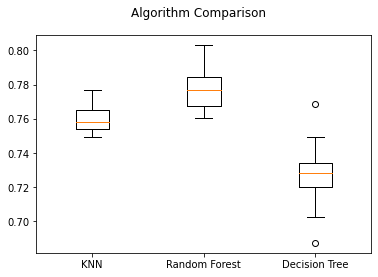

In [ ]:
# Visualisation for the K-Fold and Cross-Validation
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(models)
plt.show()

In [ ]:
# Check the k-values that have the lowest error 
def k_value_error():
  error_rate=[]
  for i in range (1,31): 
    clf=KNeighborsClassifier(n_neighbors=i)
    clf.fit(x_train,y_train)
    predict_i=clf.predict(x_test)
    error_rate.append(np.mean(predict_i!=y_test))
    error_rate
    k_value = error_rate.index(min(error_rate)) + 1 
  
# Plotting the error rate vs k range
  plt.figure(figsize=(12,6))
  plt.plot(range(1,31),error_rate,marker="o",markerfacecolor="red",
            linestyle="solid",color="green",markersize=15)
  plt.title("Error rate vs k value",fontsize=20)
  plt.xlabel("k-values",fontsize=20)
  plt.ylabel("error rate",fontsize=20)
  plt.xticks(range(1,31))
  plt.show()
  return k_value

In [ ]:
# Check the max_depth that have the lowest error for Random Forest
def m_max_depth_for_RF():
  error_rate=[]
  for m in range (1,31): 
    rfm=RandomForestClassifier(max_depth=m)
    rfm.fit(x_train,y_train)
    predict_i=rfm.predict(x_test)
    error_rate.append(np.mean(predict_i!=y_test))
    error_rate
    depth = error_rate.index(min(error_rate)) + 1 
  
# Plotting the error rate vs max depth
  plt.figure(figsize=(12,6))
  plt.plot(range(1,31),error_rate,marker="o",markerfacecolor="yellow",
          linestyle="solid",color="darkblue",markersize=15)
  plt.title("Error rate vs max depth for random forest",fontsize=20)
  plt.xlabel("max_depth",fontsize=20)
  plt.ylabel("error rate",fontsize=20)
  plt.xticks(range(1,31))
  plt.show()
  return depth

In [ ]:
# Check the max_depth that have the lowest error for Decision Tree
def m_max_depth_for_DT():
  error_rate=[]
  for m in range (1,31): 
    dtm=DecisionTreeClassifier(max_depth=m)
    dtm.fit(x_train,y_train)
    predict_i=dtm.predict(x_test)
    error_rate.append(np.mean(predict_i!=y_test))
    error_rate
    depth = error_rate.index(min(error_rate)) + 1 
  
# Plotting the error rate vs max depth
  plt.figure(figsize=(12,6))
  plt.plot(range(1,31),error_rate,marker="o",markerfacecolor="green",
          linestyle="solid",color="brown",markersize=15)
  plt.title("Error rate vs max depth for decision tree",fontsize=20)
  plt.xlabel("max_depth",fontsize=20)
  plt.ylabel("error rate",fontsize=20)
  plt.xticks(range(1,31))
  plt.show()
  return depth

In [ ]:
# Defind the K-Nearest Neighbours with parameters as a function to make a prediction. Also, make it easy to compare with other clssifications.
def KNN_result(k_value_error):
  knn = KNeighborsClassifier(n_neighbors=k_value_error)
  knn_model = knn.fit(x_train,y_train)
  y_pred = knn_model.predict(x_test)
  ac = accuracy_score(y_test, y_pred)
  conf = confusion_matrix(y_test, y_pred)
  accuracy = classification_report(y_test, y_pred)
  result = {"accuracy":accuracy, "ac":ac, "confusion matrix":conf}
  return result

In [ ]:
# Defind the Random Forest with parameters as a function to make a prediction. Also, make it easy to compare with other clssifications.
def RF_result(m_max_depth_for_RF):
  rf = RandomForestClassifier(max_depth=m_max_depth_for_RF,random_state=0)
  rf_model = rf.fit(x_train, y_train)
  y_pred = rf_model.predict(x_test)
  ac = accuracy_score(y_test, y_pred)
  conf = confusion_matrix(y_test, y_pred)
  accuracy = classification_report(y_test, y_pred, zero_division=1)
  result = {"accuracy":accuracy, "ac":ac, "confusion matrix":conf}
  return result 

In [ ]:
# Defind the Decision Tree with parameters as a function to make a prediction. Also, make it easy to compare with other clssifications.
def DT_result(m_max_depth_for_DT):
  dt = DecisionTreeClassifier(max_depth=m_max_depth_for_DT)
  dt_model = dt.fit(x_train,y_train)
  y_pred = dt_model.predict(x_test)  
  ac = accuracy_score(y_test, y_pred)
  conf = confusion_matrix(y_test, y_pred)
  accuracy = classification_report(y_test, y_pred, zero_division=1)
  result = {"accuracy":accuracy, "ac":ac, "confusion matrix":conf}
  return result 

In [ ]:
# Defind function to extract all the result from the classification functions above.
def classification_results():
    results = {}
    knn = KNN_result(k_value_error())
    rf = RF_result(m_max_depth_for_RF())
    dt = DT_result(m_max_depth_for_DT())
    results = {"K-Nearset Neighbors":knn,
               "Random Forest":rf,
               "Decision Tree":dt
               }
    return results

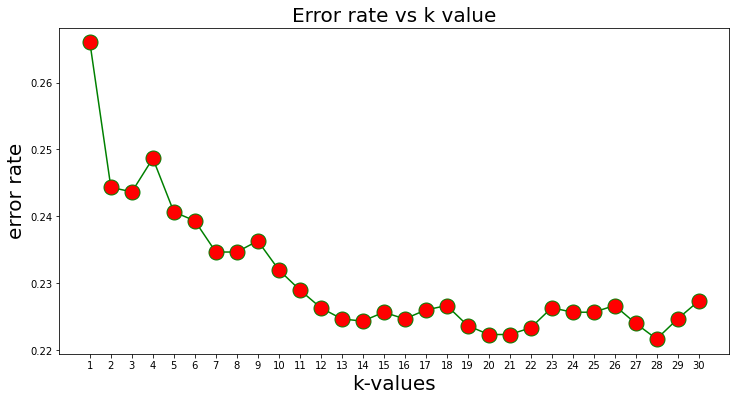

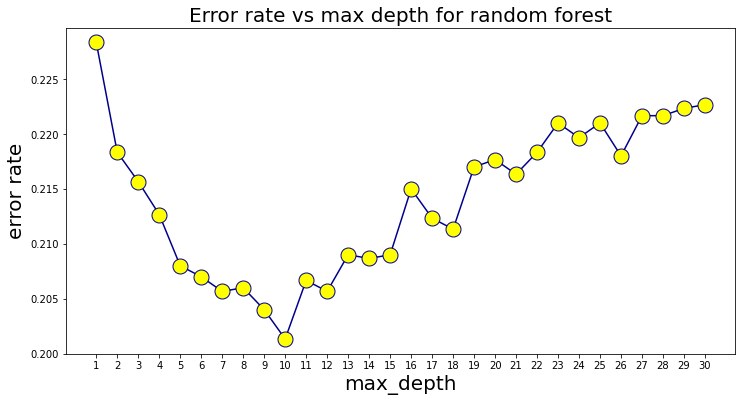

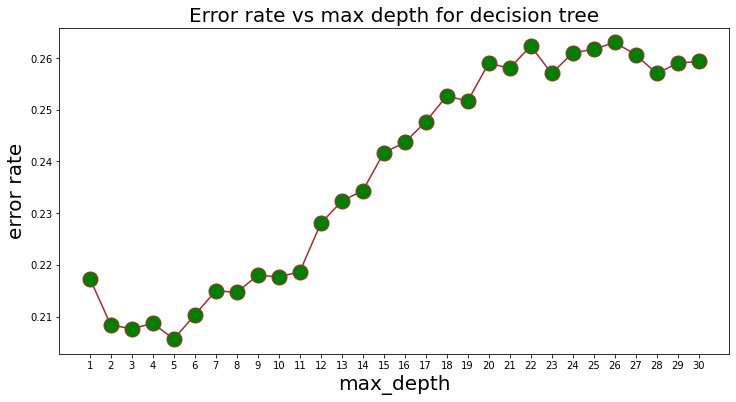

In [ ]:
# Show the result of classification with parameters
classification_results = classification_results()

In [ ]:
# Print out the classification results
print("----------Accuracy----------")
for k,r in classification_results.items():
    print(f"{k}: {r['ac']*100}","%")
print("\n----------Confusion matrix-----------")
for k,r in classification_results.items():
     print(f"{k}:\n {r['confusion matrix']}")
print("\n----------Classification Report----------")
for k,r in classification_results.items():
     print(f"{k}:\n {r['accuracy']}",'%')

----------Accuracy----------
K-Nearset Neighbors: 77.83333333333333 %
Random Forest: 79.53333333333333 %
Decision Tree: 79.46666666666667 %

----------Confusion matrix-----------
K-Nearset Neighbors:
 [[1785   15    0    0    0]
 [  77  482   24    5   12]
 [  38  220   22    8   12]
 [   7  114   14    2   13]
 [  11   74   12    9   44]]
Random Forest:
 [[1783   16    1    0    0]
 [  34  540   12    1   13]
 [   9  266   12    3   10]
 [   3  118    7    5   17]
 [   4   85    9    6   46]]
Decision Tree:
 [[1782   18    0    0    0]
 [  32  533   10    7   18]
 [   9  262    6    6   17]
 [   3  113    2    8   24]
 [   4   79    0   12   55]]

----------Classification Report----------
K-Nearset Neighbors:
               precision    recall  f1-score   support

           1       0.93      0.99      0.96      1800
           2       0.53      0.80      0.64       600
           3       0.31      0.07      0.12       300
           4       0.08      0.01      0.02       150
        

[0.7783333333333333, 0.7953333333333333, 0.7946666666666666]
['K-Nearset Neighbors', 'Random Forest', 'Decision Tree']


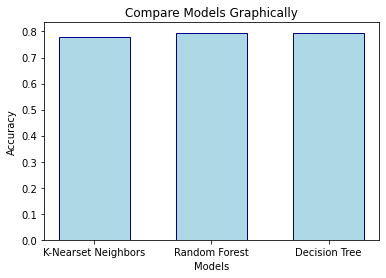

In [ ]:
# Visualisation for prediction with parameters on accuracy
accuracy = []
name = []
for k,r in classification_results.items():
    name.append(k)
    accuracy.append(r['ac'])
print(accuracy)
print(name)

fig, ax = plt.subplots(facecolor='w')
ax.bar(name, accuracy, 
       color = 'lightblue',
       edgecolor = 'darkblue',
       width =0.6)
ax.autoscale(enable=True) 
ax.set(title = "Compare Models Graphically",
       xlabel = "Models",
       ylabel = "Accuracy")
plt.show()

In [ ]:
!jupyter nbconvert  --to html 'drive/My Drive/Colab Notebooks/Domain Name Prediction System.ipynb'

[NbConvertApp] Converting notebook drive/My Drive/Colab Notebooks/Domain Name Prediction System.ipynb to html
[NbConvertApp] Writing 421395 bytes to drive/My Drive/Colab Notebooks/Domain Name Prediction System.html
